This notebook maps electrode channels (the midpoint between two contacts) to hippocmapal surfaces. Channel data are all in space-MNI152 from the Frauscher et al. atlas. Thus, to compute a hippocmapal surface in this space, we register all MICs subjects to space-MNI152 and then average hippocmapal surfaces in that space. We then map bandpower in the same was as iEEG_MICs.ipynb.

For a more detailed explanation of code, see `notebooks/iEEG.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils
import pandas as pd
import scipy.io
from scipy.signal import periodogram
import pygeodesic.geodesic as geodesic

In [2]:
micapipe_dir = '../sourcedata/Micapipe_MICs'
ieeg_dir = '../sourcedata/iEEG-BIDS' #(no ses)
ieeg_local = '../sourcedata/iEEG-local/'
hippunfold_dir = '../hippunfold/MICs_v1.3.0/hippunfold'
sub = glob.glob(ieeg_dir + '/sub-PX???')
for i in range(len(sub)): sub[i] = sub[i].split('/')[-1]
ses = 'ses-01'
den='2mm'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
ind = [range(419), range(419,483)] # index of how many dentate and hipp vertices are
shp = [419]#,64]
freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = np.array([[0.5,4], [4,8], [8,13], [13,30], [30,80]])
dist_threshold = 5 #mm

In [143]:
bp = scipy.io.loadmat(f'{ieeg_local}/Frauscher-wakefullnes.mat')
print(bp['ChannelPosition'].shape)
print(np.min(bp['ChannelPosition'],axis=0))
print(np.max(bp['ChannelPosition'],axis=0))

(1772, 3)
[-72.         -97.5        -41.19642857]
[74.         65.33333333 85.53846154]


In [149]:
# ensure same space
# these should all be postive after applying the inverse affine
ref = nib.load('/data/mica1/01_programs/micapipe-v0.2.0/MNI152Volumes/MNI152_T1_1mm.nii.gz')
V = bp['ChannelPosition'] - ref.affine[:3,3]
V[:,0] = -V[:,0]
print(np.min(V,axis=0))
print(np.max(V,axis=0))

[16.         28.5        30.80357143]
[162.         191.33333333 157.53846154]


(1, 100)

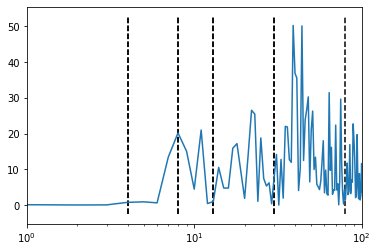

In [64]:
f, Pxx = periodogram(bp['Data'][:,0], fs=200)
plt.plot(Pxx)
#plt.yscale('log')
plt.xscale('log')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xlim(1,100)

(1, 100)

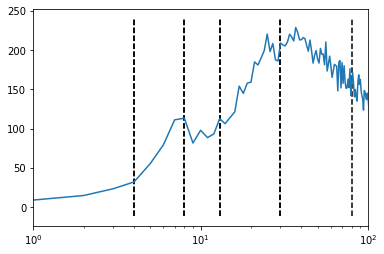

In [65]:
Pxx = np.zeros((len(Pxx),len(bp['ChannelPosition'])))
for c in range(len(bp['ChannelPosition'])):
    Pxx[:,c] = periodogram(bp['Data'][:,c], fs=200)[1]
    
plt.plot(np.mean(Pxx,axis=1))
#plt.yscale('log')
plt.xscale('log')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xlim(1,100)

In [37]:
def bandpower(x, fs, fmin, fmax):
    f, Pxx = scipy.signal.periodogram(x, fs=fs)
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [38]:
totbp = np.zeros(( bp['Data'].shape[1], len(bands)))
for b in range(len(bands)):
    for c in range(bp['Data'].shape[1]):
        totbp[c,b] = bandpower(bp['Data'][:,c],freq,band_lims[b][0],band_lims[b][1])

/tmp/ipykernel_14864/826348525.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


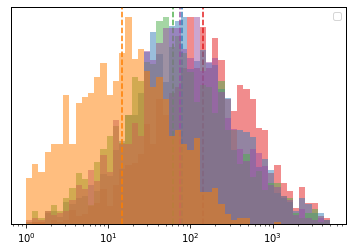

In [66]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = totbp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [108]:
# register hippocampal surfaces to MNI152, and then average hippocampal surfaces
surfL = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
surfR = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
vertices = np.stack((surfL.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data,surfR.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data),axis=2)
faces = surfL.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data


In [13]:
dist_threshold = 5 #mm
hipp_dat_count = np.zeros([sum(shp)])
hipp_dat = np.ones([sum(shp),2,5,len(bp['ChannelPosition'])])*np.nan
hipp_dat_perio = np.ones([sum(shp),2,Pxx.shape[0],len(bp['ChannelPosition'])])*np.nan

for h in range(len(hemi)):
    for i in range(len(bp['ChannelPosition'])):
        for v in range(len(vertices)):
            dist = np.linalg.norm(bp['ChannelPosition'][i]-vertices[v,:,h])
            if dist <= dist_threshold:
                hipp_dat[v,h,:,i] = totbp[i,:]
                hipp_dat_perio[v,h,:,i] = Pxx[:,i]

In [14]:
print('number of L hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_dat[:,0,0,:]),axis=0))[0])))
print('number of R hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_dat[:,1,0,:]),axis=0))[0])))

number of L hemis: 19
number of R hemis: 0


/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


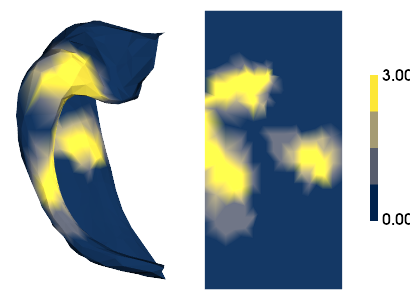

In [15]:
hipp_dat_count = np.sum(~np.isnan(hipp_dat),axis=(1,3))[:,0]
plotting.surfplot_canonical_foldunfold(hipp_dat_count, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(1, 100)

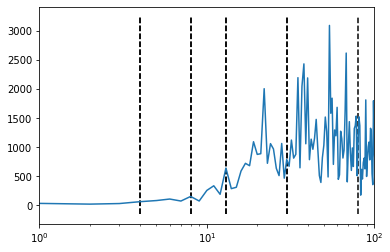

In [170]:
plt.plot(np.nanmean(hipp_dat_perio,axis=(0,1,3)))
#plt.yscale('log')
plt.xscale('log')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xlim(1,100)

/tmp/ipykernel_14864/1113241225.py:16: UserWarning: Legend does not support <AxesSubplot:> instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(handles=ax[1:])


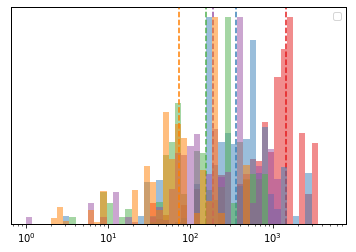

In [107]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_dat[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1),np.log10(5000), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

In [132]:
# cominbing BP across channels and vertices for visualization
# here, we exctrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_dat = np.zeros((hipp_dat.shape[0],2,hipp_dat.shape[3]))
interp_hipp_dat = np.zeros([hipp_dat.shape[0],5])
interp_hipp_perio_dat = np.zeros([hipp_dat.shape[0],len(Pxx)])

for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):
        for c in range(hipp_dat.shape[3]):
            dat = hipp_dat[:,h,0,c]
            mask = ~np.isnan(dat[ind[l]])
            if np.any(mask):
                geoalg = geodesic.PyGeodesicAlgorithmExact(vertices[:,:,h], faces)
                sd,_ = geoalg.geodesicDistances(np.where(mask)[0], None)
                weights_hipp_dat[ind[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_dat, axis=(1,2))
for v in range(weights_hipp_dat.shape[0]):
    for h in range(2):
        for c in range(hipp_dat.shape[3]):
            w = weights_hipp_dat[v,h,c] / totweights[v]
            if w>0:
                interp_hipp_dat[v,:] += np.nanmean(hipp_dat[:,h,:,c],axis=0) * w
                interp_hipp_perio_dat[v,:] += np.nanmean(hipp_dat_perio[:,h,:,c],axis=0) * w

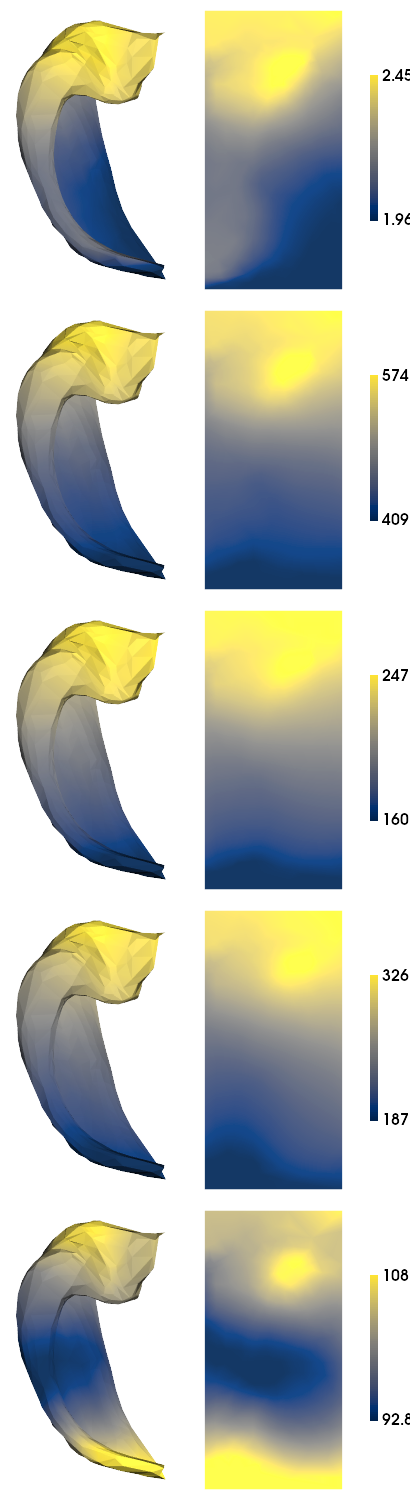

In [135]:
plotting.surfplot_canonical_foldunfold(interp_hipp_dat, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

# Band power gradients

In [167]:
from brainspace.gradient import GradientMaps
# gradient decomposition
bpgm = GradientMaps(n_components=5, kernel='normalized_angle')
bpgm.fit(interp_hipp_perio_dat)

GradientMaps(kernel='normalized_angle', n_components=5)

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


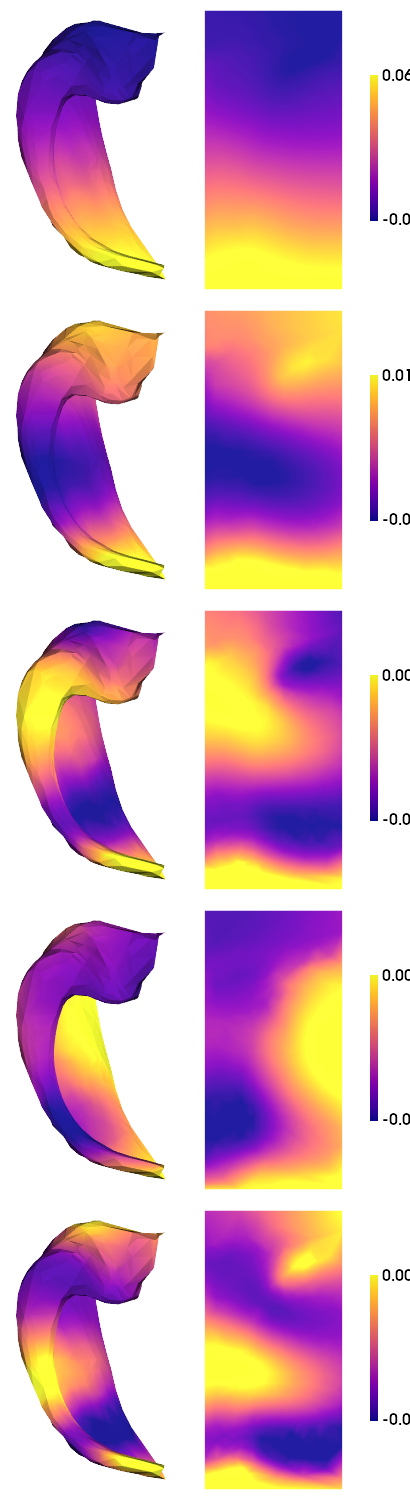

In [168]:
plotting.surfplot_canonical_foldunfold(bpgm.gradients_, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='plasma', share='row', color_bar='right', embed_nb=True)

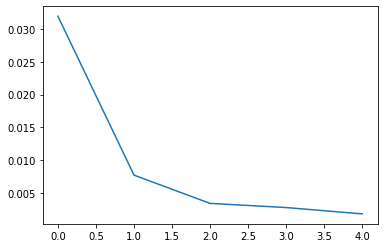

In [162]:
plt.plot(bpgm.lambdas_)

(1, 100)

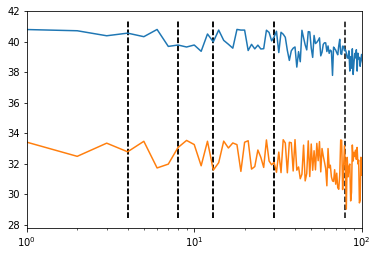

In [163]:
# compare top to bottom

nverts = np.sum(shp)
nvertsplit = int(nverts*.25)

bot = np.argpartition(bpgm.gradients_[:,0],nvertsplit)[:nvertsplit]
top = np.argpartition(bpgm.gradients_[:,0],-nvertsplit)[-nvertsplit:]

plt.plot(np.mean(interp_hipp_perio_dat[bot,:],axis=1))
plt.plot(np.mean(interp_hipp_perio_dat[top,:],axis=1))
#plt.yscale('log')
plt.xscale('log')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xlim(1,100)

In [18]:
# save everything
import shelve
filename='../checkpoints/iEEG_Frauscher.out'
my_shelf = shelve.open(filename,'n') # 'n' for new
for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        # __builtins__, my_shelf, and imported modules can not be shelved.
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

ERROR shelving: __builtin__
ERROR shelving: __builtins__
ERROR shelving: exit
ERROR shelving: geodesic
ERROR shelving: get_ipython
ERROR shelving: glob
ERROR shelving: hipp_dat_perio
ERROR shelving: my_shelf
ERROR shelving: nib
ERROR shelving: np
ERROR shelving: pd
ERROR shelving: pl
ERROR shelving: plotting
ERROR shelving: plt
ERROR shelving: quit
ERROR shelving: scipy
ERROR shelving: shelve
ERROR shelving: sys
ERROR shelving: utils


In [11]:
# load everything
import shelve
filename='../checkpoints/iEEG_Frauscher.out'
my_shelf = shelve.open(filename)
for key in my_shelf:
    try:
        globals()[key]=my_shelf[key]
    except:
        print('not loaded: ' + key)
my_shelf.close()

not loaded: bandpower
